In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install -q imagecorruptions

In [3]:
from utils import *
from utils.callbacks.cyclicLR import CyclicLR
from utils.callbacks.metrics import ClassificationMetrics

In [4]:
loader = DataLoader(split_method='balanced_epochs')

print('\nTrain data distribution')
loader.print_data_distribution('train', False)

print('\nValidation data distribution')
loader.print_data_distribution('val', False)

Class weights: {0: 0.9786206896551725, 1: 1.0074036511156186, 2: 1.0990871369294606, 3: 0.9210725600803648, 4: 1.010135593220339}
Total train: 59598, Total val: 1085

Train data distribution
3    12941
0    12180
1    11832
4    11800
2    10845
Name: label, dtype: int64

Validation data distribution
4    217
3    217
2    217
1    217
0    217
Name: label, dtype: int64


Train data
Batch X:  (4, 512, 512, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


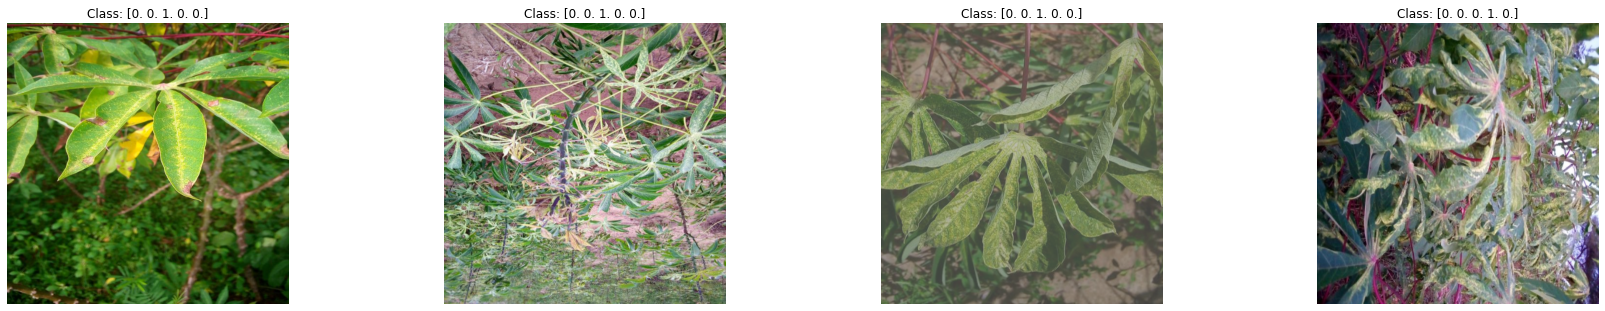

In [5]:
print('Train data')
loader.view_data(data='train', batch_size=4)

Validation data
Batch X:  (4, 512, 512, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


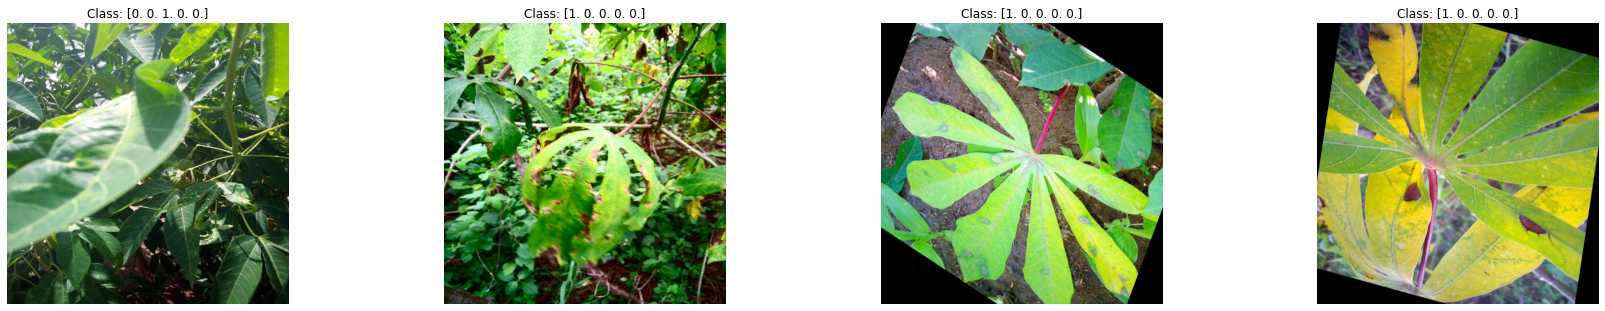

In [6]:
print('Validation data')
loader.view_data(data='val', batch_size=4)

In [7]:
with tf.distribute.MirroredStrategy().scope():
    model = Model()
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

## Model fitting

In [ ]:
# start training
model.fit(
    x=loader.flow('train', batch_size=BATCH_SIZE),
    steps_per_epoch=loader.data_size('train')//(2*BATCH_SIZE),
    
    class_weight=loader.class_weights,
    
    epochs=100,
    callbacks=[
        ClassificationMetrics(loader.flow('val', batch_size=2, augment=False), loader.data_size('val')//2, 
                              f'model.h5', mode='categorical'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                                        mode='min', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                             verbose=1, mode='min', min_lr=1e-6, min_delta=0.01),
        tf.keras.callbacks.CSVLogger(filename='training_log.csv', separator=',', append=True),
        CyclicLR(base_lr=1e-4, max_lr=3e-4, step_size=loader.data_size('train')//(2*BATCH_SIZE), 
                 mode='exp_range', gamma=0.99)
              ],
    
    validation_data=loader.flow('val', batch_size=2, augment=False),
    validation_steps=loader.data_size('val')//2,
    
    use_multiprocessing=True
)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:batch_all_reduce: 422 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 422 all-reduces with algorithm = nccl, num_packs = 1
 724/3724 [====>.........................] - ETA: 18:54 - loss: 0.2796 - acc: 0.5243

In [ ]:
model.load_weights('model.h5')

In [ ]:
plot_loss(model.history, '', 0)

In [ ]:
# evaluate model
loader.evaluate(model, tta=1)

In [ ]:
# evaluate model
loader.evaluate(model, tta=10)

In [ ]:
loader.create_submission(
    model = model,
    path_to_csv = '../input/cassava-leaf-disease-classification/sample_submission.csv',
    path_to_images = '../input/cassava-leaf-disease-classification/test_images/'
)